In [1]:
import sys
# sys.path.append('/home/ajhnam/plinko_nn/src')
# sys.path.append('/home/plinkoproj/plinko_nn/src')
sys.path.append('../src')
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from plinko.misc import data_utils
from plinko.misc.simulation_dataset import SimulationDataset
from plinko.model.predictor_gru import GRUPredictor
from plinko.misc import plot as plinko_plot

# import matplotlib.pyplot as plt
# from plotnine import *
# %matplotlib inline

In [ ]:
# device = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(0)
torch.manual_seed(0)
torch.set_default_tensor_type('torch.FloatTensor')
epsilon = sys.float_info.epsilon

In [ ]:
# repo_path = '/home/plinkoproj/plinko_nn'
repo_path = '../'
# df_ball = pd.read_feather(repo_path + '/data/simulations/sim_ball.feather')
# df_env = pd.read_feather(repo_path + '/data/simulations/sim_environment.feather')
# df_col = pd.read_feather(repo_path + '/data/simulations/sim_collisions.feather')

df_ball = pd.read_feather(repo_path + '/data/training/sim_ball.feather')
df_env = pd.read_feather(repo_path + '/data/training/sim_environment.feather')
df_col = pd.read_feather(repo_path + '/data/training/sim_collisions.feather')

In [ ]:
sim_data = data_utils.get_sim_data(df_ball, df_col)
selected_runs = sim_data[(sim_data.num_collisions <= 2)
                         & (sim_data.duration < 80)
                         & (sim_data.run <= 20)]
simulations, environments = data_utils.create_task_df(selected_runs, df_ball, df_env)
states, envs = data_utils.to_tensors(simulations, environments, device)

In [ ]:
print(selected_runs)
simulations.t.max()

In [ ]:
def get_logp_loss(gm, targets):
    return -gm.log_p(targets).mean()

def get_mu_mse_loss(gm, targets):
    return F.mse_loss(gm.mu[:,:,0], targets)

In [ ]:
model = GRUPredictor(env_size=11, state_size=2, num_gaussians=2).to(device)
# optimizer = optim.SGD(model.parameters(), lr=.001)
optimizer = optim.Adam(model.parameters(), lr = 2e-4, weight_decay=.001)
dataset = SimulationDataset(envs, states)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

# print(dataloader)

# for batch_i, batch in enumerate(dataloader):
#     if batch_i == 0:
#         print(batch_i)
#         print(batch['states'][0])
#         print(batch['targets'][0])

In [ ]:
max_t = simulations.t.max()
epochs = 1000
losses = []
mu_overtime = []
sigma_overtime = []
target_overtime = []
for epoch in tqdm(range(epochs+1)):
# for epoch in tqdm(range(10)):
    epoch_loss = 0
    epoch_mse_loss = 0
    epoch_logp_loss = 0
    for batch_i, batch in enumerate(dataloader):
        optimizer.zero_grad()
            
        gm = model(batch['envs'], batch['states'], 0)
        targets = batch['targets']
        
        logp_loss = get_logp_loss(gm, targets)
        mse_loss = 10*get_mu_mse_loss(gm, targets)
        loss = logp_loss # + mse_loss
        loss.backward(retain_graph=True)
        optimizer.step()
        epoch_loss += loss
        epoch_logp_loss += logp_loss
        epoch_mse_loss += mse_loss
        losses.append((epoch, batch_i, float(loss)))
        
        
        if batch_i == 0:
            gm_mu = gm.mu[:,:,0]
            target_mu = targets
            gm_sigma = gm.sigma[:,:,0]
        
    mu_overtime.append(gm_mu)
    sigma_overtime.append(gm_sigma)
    target_overtime.append(target_mu)    

    
    if epoch%10 == 0:
        print('Epoch {} | logp: {} | mse: {} | total: {}'.format(epoch,
                                                                 round(float(epoch_logp_loss), 4),
                                                                 round(float(epoch_mse_loss), 4),
                                                                 round(float(epoch_loss), 4)))

    
torch.save(model.state_dict(), 'gru.model')
torch.save(mu_overtime, 'mu_overtime.pt')
torch.save(sigma_overtime, 'sigma_overtime.pt')
torch.save(target_overtime, 'target_overtime.pt')
torch.save(losses, 'losses.pt')

In [2]:
mu_overtime = torch.load('mu_overtime.pt')
sigma_overtime = torch.load('sigma_overtime.pt')
# target_overtime = torch.load('target_overtime.pt')
# losses = torch.load('losses.pt')

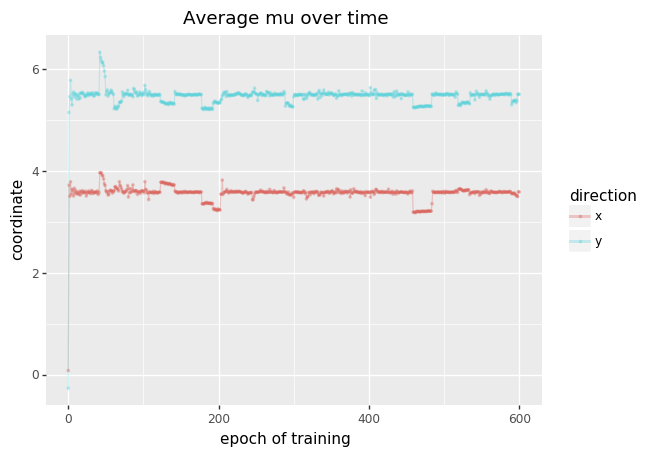

<ggplot: (8777063508237)>


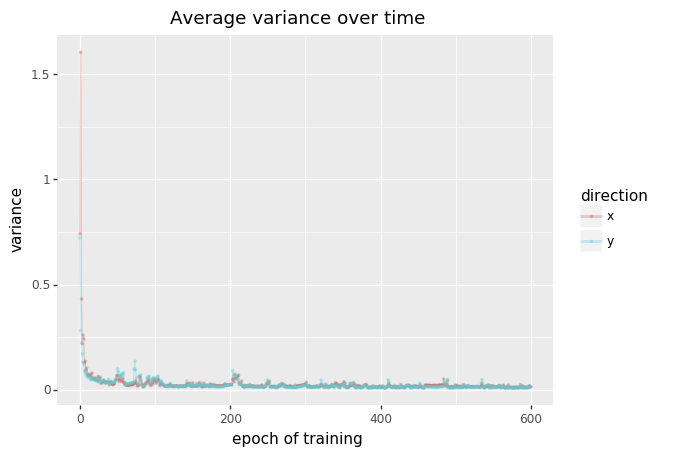

<ggplot: (8777062326185)>


In [3]:
# print(losses)
# plinko_plot.plot_losses(losses)
plinko_plot.plot_mu_over_time(mu_overtime)
plinko_plot.plot_variance_over_time(sigma_overtime)

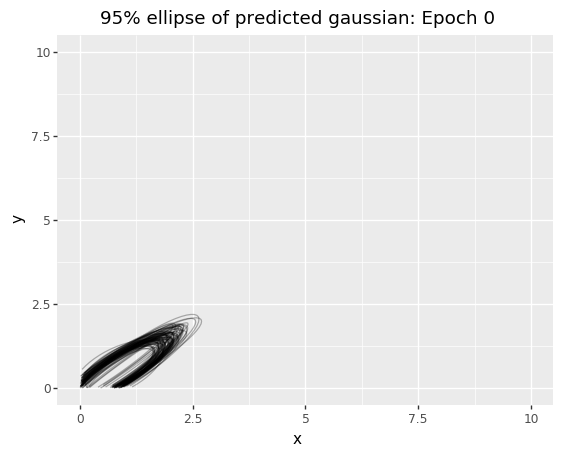

<ggplot: (8748898580449)>


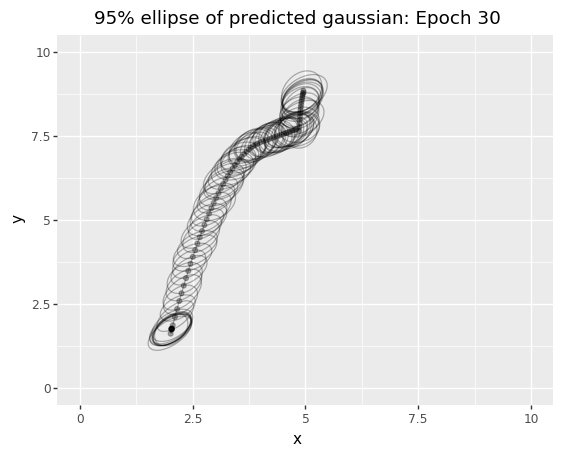

<ggplot: (8748772668421)>


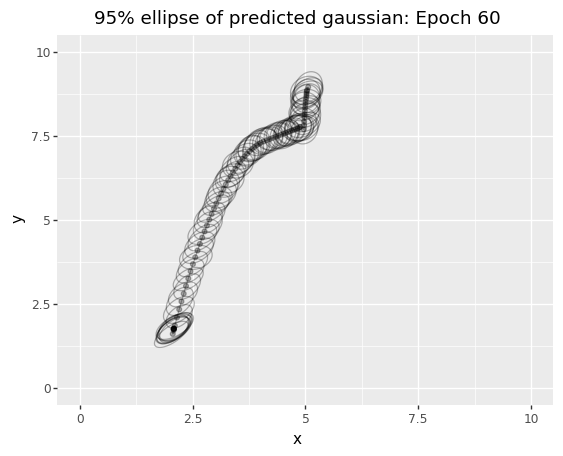

<ggplot: (8748772252769)>


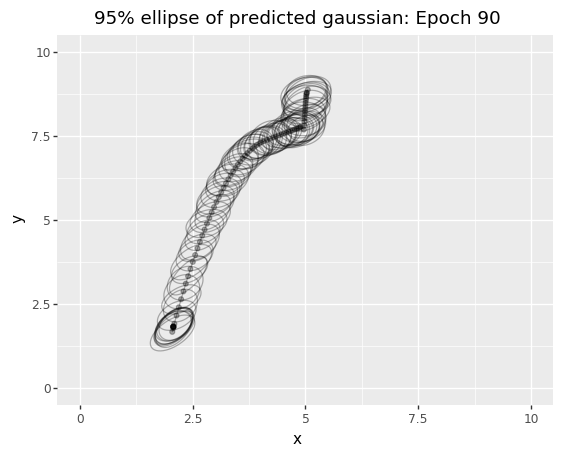

<ggplot: (8748771828881)>


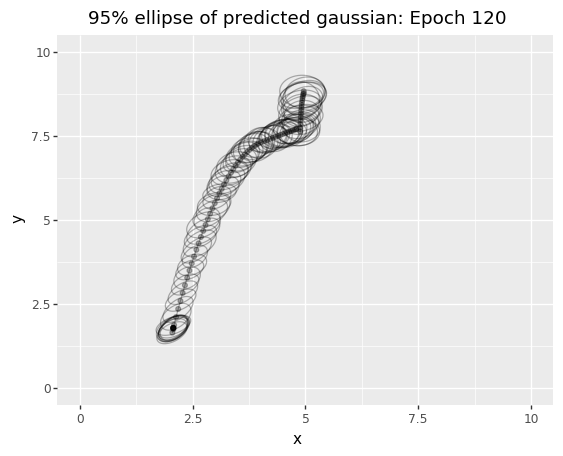

<ggplot: (8748771810993)>


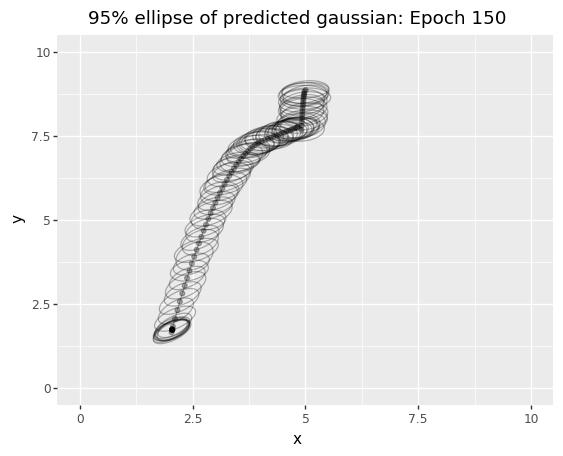

<ggplot: (8748771714921)>


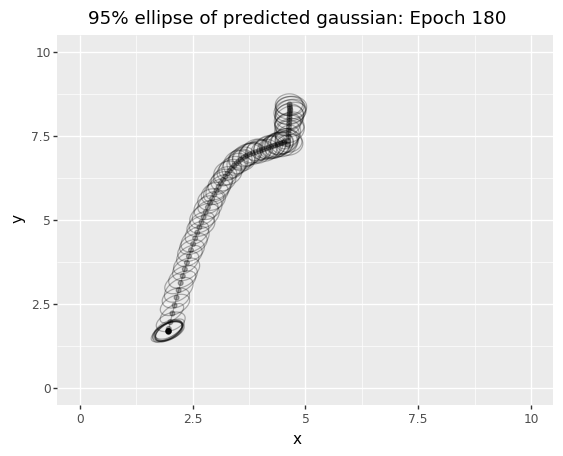

<ggplot: (8748768951257)>


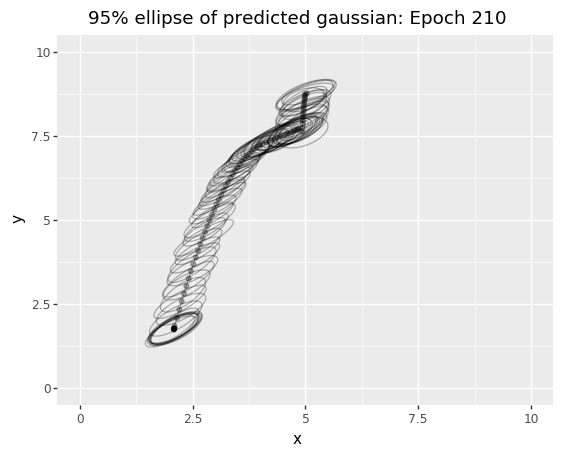

<ggplot: (8748770771433)>


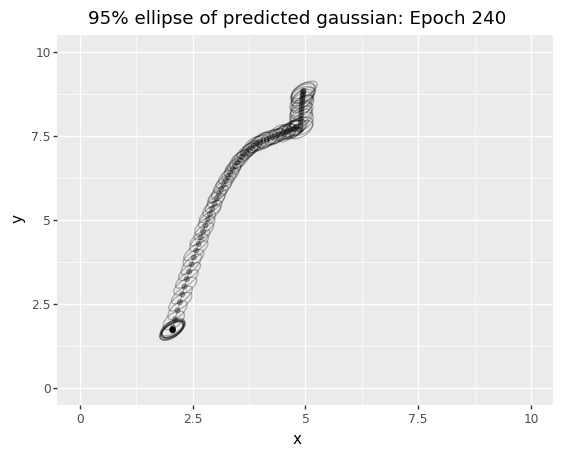

<ggplot: (8748772294277)>


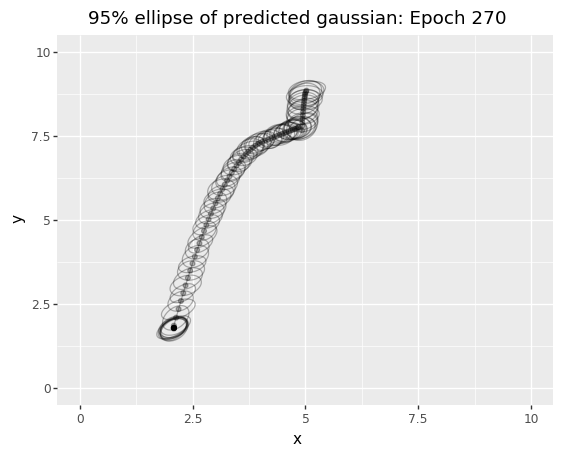

<ggplot: (8748768795641)>


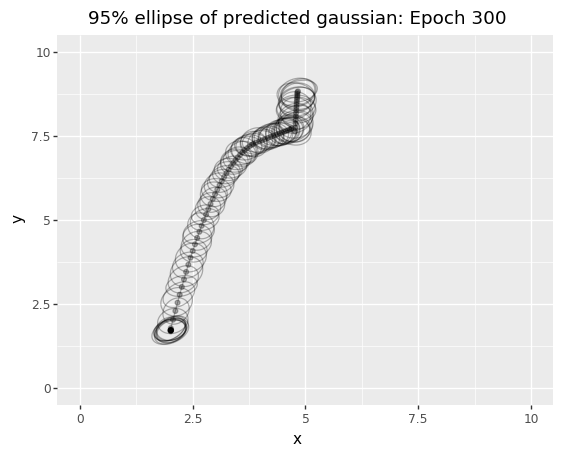

<ggplot: (8748768739557)>


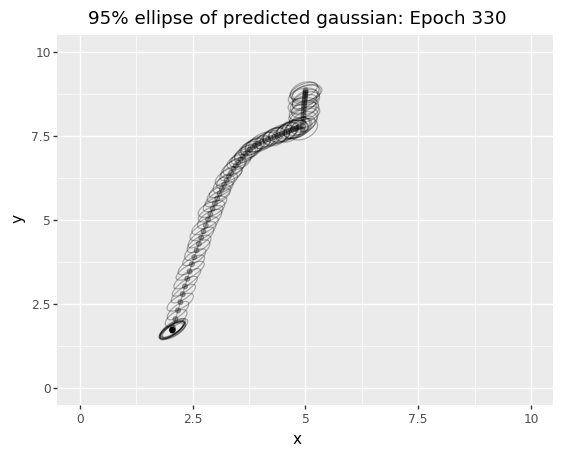

<ggplot: (8748768564297)>


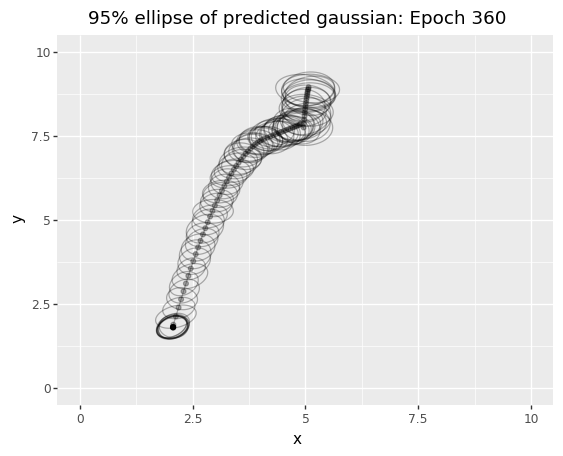

<ggplot: (8748768477141)>


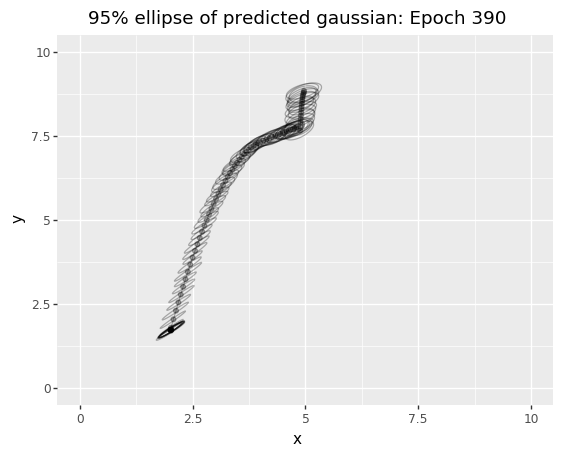

<ggplot: (8748770929213)>


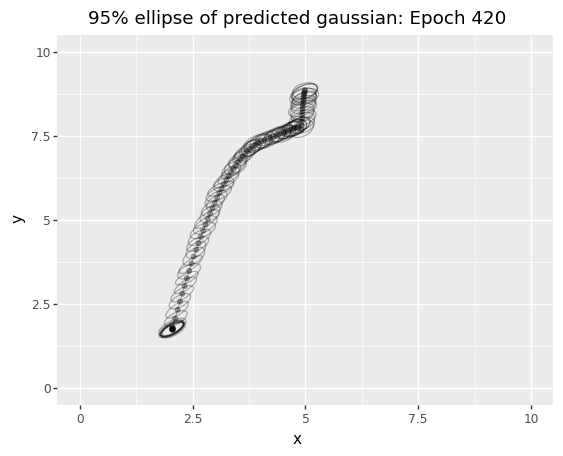

<ggplot: (8748771808745)>


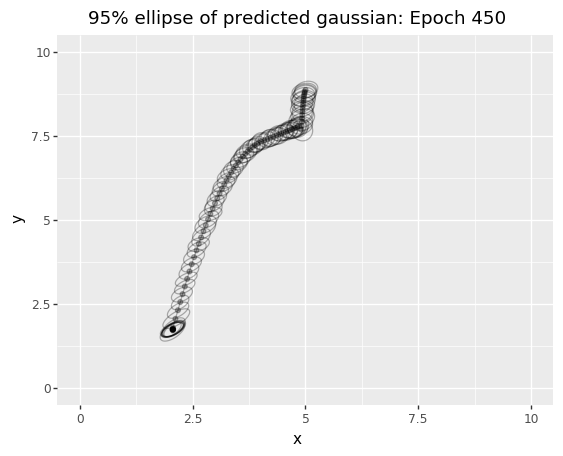

<ggplot: (8748771797177)>


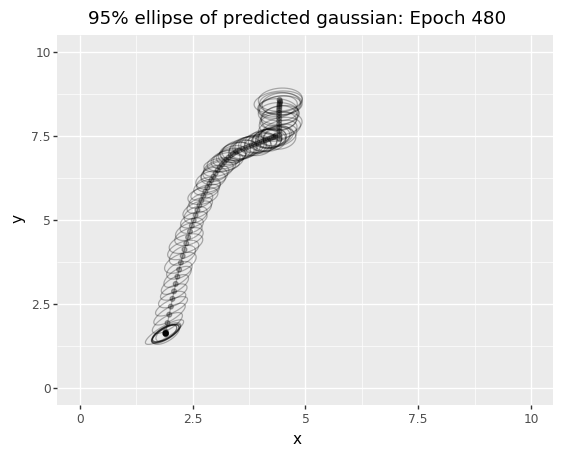

<ggplot: (8748771745717)>


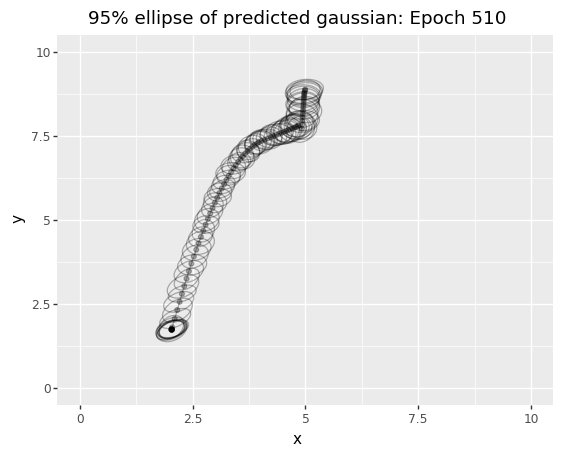

<ggplot: (8748770850609)>


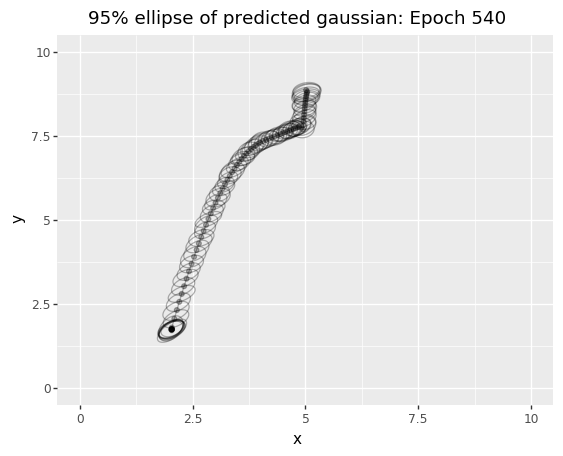

<ggplot: (8748770878649)>


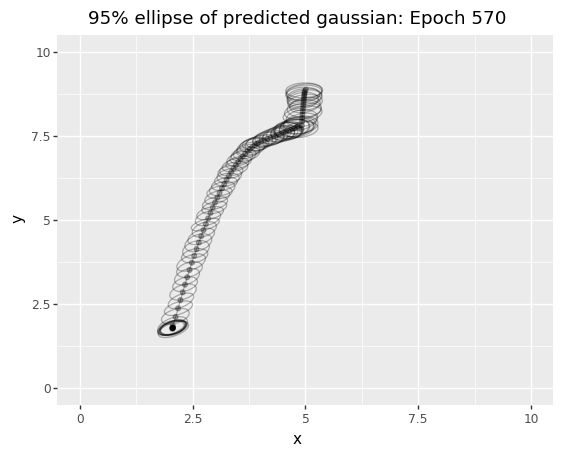

<ggplot: (8748768810889)>


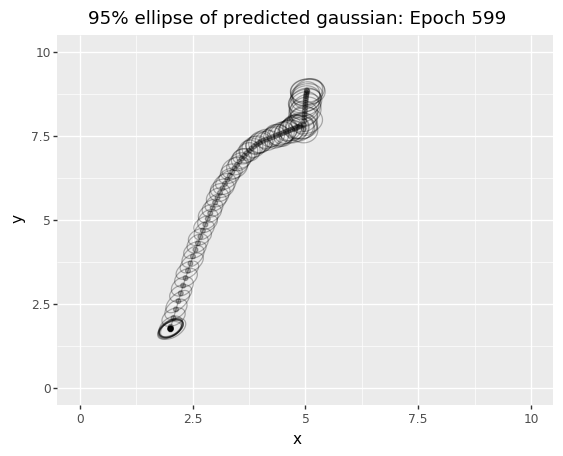

<ggplot: (8748768794429)>


In [3]:
for t in range(600):
    if t %30 == 0 or t == 599:
        plinko_plot.plot_pred_gaussian(mu_overtime[t], None, sigma_overtime[t], sim_index = 0, 
                                   title = "95% ellipse of predicted gaussian: Epoch {}".format(t), color = 'red')